Spotify Data for AI Demo by Elyssa McMaster at AI Summer School 2025

Let's learn how to build a Spotify app with your data!! Every day can be Spotify Wrapped day with the right skillset :)

I've included the QR code to access the demo below. I recommend making a duplicate notebook in your own Google Drive. You are welcome to share the demo with anyone interested!

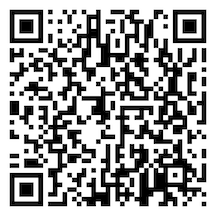

For this project, you need a Spotify account. If you have a Spotify account, you're good to go! Everything in this tutorial should get you started. First, install spotipy....

In [ ]:
!pip install spotipy --quiet

Clear your cache every time to prevent errors...


In [ ]:
import os
for f in [".cache", ".cache-simple", ".cache-colab"]:
    try: os.remove(f)
    except FileNotFoundError: pass

import spotipy
from spotipy.oauth2 import SpotifyOAuth

We need to access Spotify for Developers to get your own data.

Go to https://developer.spotify.com/dashboard

Click "create app"

Name your project whatever you'd like. You can only have 3 at a time, so you can delete previous projects if there's something else you'd like to do later.

Select "Web API"

Click on your new app. You'll get a client ID, a client secret (click "View client secret"), and a redirect URI. The redirect URI can be a live website that ends in /callback; I use https://elyssamcmaster.github.io/callback

You'll need to input the EXACT URI into Redirect URIs in Spotify.

In [ ]:
SPOTIPY_CLIENT_ID = "your-client-id"
SPOTIPY_CLIENT_SECRET = "your-client-secret"
SPOTIPY_REDIRECT_URI = "your-redirect-uri" ## if you have a github.io site I would use that becasue I know it works in my case

Spotify has a few scopes you can choose from, but I know this one works. You can look into the docs if you'd like a different scope.

In [ ]:
scope = "user-read-recently-played user-top-read user-library-read"

In [ ]:
# Create the OAuth helper
sp_oauth = SpotifyOAuth(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET,
    redirect_uri=SPOTIPY_REDIRECT_URI,
    scope=scope,
    cache_path=".cache-colab",
    open_browser=False,  # we'll paste the URL manually
)

In [ ]:
# Get the login URL
auth_url = sp_oauth.get_authorize_url()
print("Click this URL, log in, approve, then copy the FULL address bar URL you land on:")
print(auth_url)

In [ ]:
# Paste the FULL redirect URL (must include ?code=...&state=...)
redirect_response = input("\nPaste FULL redirect URL here: ").strip()

In [ ]:
code = sp_oauth.parse_response_code(redirect_response)
token_info = sp_oauth.get_access_token(code)
sp = spotipy.Spotify(auth=token_info["access_token"])

If you see your spotify username in the next cell, you've successfully logged in :)

In [ ]:
# Quick proof
print("Logged in as:", sp.me()["display_name"])

Now, let's get your data...

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Get recent + top tracks ====
recent = sp.current_user_recently_played(limit=10)
top = sp.current_user_top_tracks(limit=10, time_range="medium_term")
track_ids = []
track_names = {}

for item in recent["items"]:
    tid = item["track"]["id"]
    track_ids.append(tid)
    track_names[tid] = f"{item['track']['name']} — {item['track']['artists'][0]['name']}"

for item in top["items"]:
    tid = item["id"]
    track_ids.append(tid)
    track_names[tid] = f"{item['name']} — {item['artists'][0]['name']}"

# unique IDs only
track_ids = list(set(track_ids))
print(track_ids)
print(f"Found {len(track_ids)} unique tracks")
print(track_names, end="\n\n")

And plot them...

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

recent = sp.current_user_recently_played(limit=50)
rows = [{
    "artist": it["track"]["artists"][0]["name"],
    "duration_min": it["track"]["duration_ms"]/60000.0
} for it in recent["items"] if it.get("track")]

df = pd.DataFrame(rows)
by_artist = df.groupby("artist")["duration_min"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(by_artist.index, by_artist.values)
plt.gca().invert_yaxis()
plt.xlabel("Total minutes (last 50 plays)")
plt.title("Who you actually spent time with")
plt.tight_layout(); plt.show()

Artist count..

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

artists = [it["track"]["artists"][0]["name"] for it in items]
counts = Counter(artists)
labels, sizes = zip(*counts.most_common(10))  # top 10

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Top Artists (recent plays)")
plt.show()

Now, based on your recent listening, what will you listen to next?

In [ ]:
import math, random, numpy as np
import pandas as pd
from collections import defaultdict, Counter

# =========================
# Tunable knobs
# =========================
N_HISTORY   = 300    # how many recent plays to fetch
DECAY_BASE  = 0.97   # recency decay per step (0.97 ~= half-life ~23 plays)
ALPHA       = 0.15   # smoothing so unseen options still get tiny mass
TEMPERATURE = 0.8    # >1 = more random, <1 = sharper
TOP_K       = 5      # how many final suggestions to return
DIVERSE_ARTISTS = True

# =========================
# 1) Fetch a larger history (newest -> oldest)
# =========================
def fetch_history(sp, limit_total=N_HISTORY):
    items, before = [], None
    while len(items) < limit_total:
        batch = sp.current_user_recently_played(limit=50, before=before)
        b = batch.get("items", [])
        if not b: break
        items.extend(b)
        last_ts = pd.Timestamp(b[-1]["played_at"])
        before = int(last_ts.timestamp() * 1000)
    return items

items = fetch_history(sp, N_HISTORY)
if not items:
    raise ValueError("No recent plays found.")

# chronological: oldest -> newest
seq = [it["track"]["id"] for it in items[::-1] if it.get("track") and it["track"].get("id")]
name_lookup = {it["track"]["id"]: f'{it["track"]["name"]} — {it["track"]["artists"][0]["name"]}'
               for it in items if it.get("track")}
artist_lookup = {it["track"]["id"]: it["track"]["artists"][0]["id"] for it in items if it.get("track")}
print(f"Training on {len(seq)} plays.")

if len(seq) < 10:
    print("Not much to learn from yet — predictions may be repetitive.")

# =========================
# 2) Build weighted n-gram tables
# =========================
tri = defaultdict(float)        # (a,b,c) weighted counts as dict keyed by tuple -> weight
bi  = defaultdict(float)        # (b,c)
uni = defaultdict(float)        # (c)

# add recency weight: newer transitions get higher weight
# index i is position of left item; more recent = larger i
L = len(seq)
def w(i): return DECAY_BASE ** (L - 1 - i)

# unigrams & bigrams
for i in range(L-1):
    b, c = seq[i], seq[i+1]
    wt = w(i)
    uni[c] += wt
    bi[(b, c)] += wt

# trigrams
for i in range(L-2):
    a, b, c = seq[i], seq[i+1], seq[i+2]
    wt = w(i)
    tri[(a, b, c)] += wt

# Convert to maps of next->score
tri_map = defaultdict(Counter)
bi_map  = defaultdict(Counter)
uni_ctr = Counter()

for (a,b,c), wt in tri.items(): tri_map[(a,b)][c] += wt
for (b,c), wt in bi.items():    bi_map[b][c]     += wt
for c, wt in uni.items():       uni_ctr[c]       += wt

# =========================
# 3) Backoff scoring (tri -> bi -> uni)
# =========================
def score_next(context_ids, alpha=ALPHA):
    """Return Counter of candidate next tracks with smoothed scores."""
    if len(context_ids) >= 2 and tri_map.get((context_ids[-2], context_ids[-1])):
        base = tri_map[(context_ids[-2], context_ids[-1])]
    elif len(context_ids) >= 1 and bi_map.get(context_ids[-1]):
        base = bi_map[context_ids[-1]]
    else:
        base = uni_ctr

    # smoothing (tiny mass to everyone in uni space)
    scores = Counter(base)
    total_uni = sum(uni_ctr.values()) or 1.0
    for tid in uni_ctr.keys():
        scores[tid] += alpha * (uni_ctr[tid] / total_uni)
    return scores

# =========================
# 4) Exploration: same artist & related artists
# =========================
def enrich_with_exploration(sp, context_ids, scores, boost=0.3):
    try:
        last_id = context_ids[-1]
    except IndexError:
        return scores

    # same-artist top tracks
    try:
        a_id = artist_lookup.get(last_id)
        if not a_id:
            a_id = sp.track(last_id)["artists"][0]["id"]
            artist_lookup[last_id] = a_id
        top_same = sp.artist_top_tracks(a_id, country="US")["tracks"]
        for t in top_same[:10]:
            tid = t["id"]
            if tid not in scores:
                scores[tid] += boost
                name_lookup.setdefault(tid, f'{t["name"]} — {t["artists"][0]["name"]}')
                artist_lookup.setdefault(tid, t["artists"][0]["id"])
    except Exception:
        pass

    # related artists' top tracks
    try:
        rel = sp.artist_related_artists(a_id)["artists"][:5]
        for ra in rel:
            tt = sp.artist_top_tracks(ra["id"], country="US")["tracks"][:2]
            for t in tt:
                tid = t["id"]
                if tid not in scores:
                    scores[tid] += boost * 0.7
                    name_lookup.setdefault(tid, f'{t["name"]} — {t["artists"][0]["name"]}')
                    artist_lookup.setdefault(tid, t["artists"][0]["id"])
    except Exception:
        pass

    return scores

# =========================
# 5) Temperature sampling with artist diversity
# =========================
def sample_diverse(scores, k=TOP_K, temperature=TEMPERATURE, avoid_ids=None):
    avoid_ids = set(avoid_ids or [])
    # remove obviously bad/looping candidates
    for tid in list(scores.keys()):
        if tid in avoid_ids:
            scores.pop(tid, None)

    if not scores:
        return []

    # softmax over scores/temperature
    keys = list(scores.keys())
    vals = np.array([scores[k] for k in keys], dtype=float)
    vals = vals / (temperature if temperature > 0 else 1.0)
    vals = vals - vals.max()
    probs = np.exp(vals)
    probs = probs / probs.sum()

    picks = []
    used_artists = set()
    for _ in range(k):
        if len(keys) == 0: break
        idx = np.random.choice(len(keys), p=probs)
        tid = keys[idx]

        # enforce artist diversity if requested
        if DIVERSE_ARTISTS:
            art = artist_lookup.get(tid)
            if art in used_artists:
                # downweight and resample once
                probs[idx] *= 0.01
                probs = probs / probs.sum()
                continue
            used_artists.add(art)

        picks.append(tid)
        # remove chosen item (without replacement)
        keys.pop(idx)
        probs = np.delete(probs, idx)
        if probs.sum() > 0:
            probs = probs / probs.sum()
        else:
            break
    return picks

# =========================
# 6) Predict now
# =========================
context = seq[-3:]  # last 3 plays
cand = score_next(context)
cand = enrich_with_exploration(sp, context, cand)
avoid = set(context)  # don’t immediately recommend what you just heard
picks = sample_diverse(cand, k=TOP_K, temperature=TEMPERATURE, avoid_ids=avoid)

print("\n🔮 Next-up suggestions:")
for i, tid in enumerate(picks, 1):
    print(f"{i}. {name_lookup.get(tid, tid)}")